# Term Project - M&M Movie Reviews

In [57]:
import pandas as pd 
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib as plt
plt.rcParams['figure.figsize'] = (10,10)

## Create dataset from GroupLens data
The data we downloaded can be found [here](https://grouplens.org/datasets/movielens/). The attributes in this dataset are: 
- Movie IDs: corresponds with ID used on MovieLens website (ex: id1 corresponds with https://movielens.org/movies/1) 
- Title: entered manually or imported 
- Genre: pipe separated list 
- imdbID: identifier for movie used by imdb (http://www.imdb.com)
- tmdbID: identifier for tmdbId (https://www.themoviedb.org) 
- userID: the id of the user 
- rating: on 5 star scale with half-star increments 
- timestamp: seconds since midnight Coordinated Universal Time of January 1, 1970 
- tag: user-generated metadata about movies 

From the README of where we got the data, the "dataset describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018."

In [3]:
movies = pd.read_csv('ml-latest-small/movies.csv')
links = pd.read_csv('ml-latest-small/links.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')

In [4]:
print(movies.shape)
print(movies.columns)
print("----------")
print(links.shape)
print(links.columns)
print("----------")
print(ratings.shape)
ratings.rename(columns={'timestamp':'rating_timestamp'}, inplace=True)
print(ratings.columns)
print("----------")
print(tags.shape)
tags.rename(columns={'timestamp':'tags_timestamp'}, inplace=True)
print(tags.columns)

(9742, 3)
Index(['movieId', 'title', 'genres'], dtype='object')
----------
(9742, 3)
Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')
----------
(100836, 4)
Index(['userId', 'movieId', 'rating', 'rating_timestamp'], dtype='object')
----------
(3683, 4)
Index(['userId', 'movieId', 'tag', 'tags_timestamp'], dtype='object')


In [5]:
movie_links = pd.merge(movies, links, on=['movieId'], how="inner")
ratings_tags = pd.merge(ratings, tags, on=['userId', 'movieId'], how="inner")
data = pd.merge(movie_links, ratings_tags, on=['movieId'], how="inner")
print(data.shape)
print(data.columns)
data.head()

(3476, 10)
Index(['movieId', 'title', 'genres', 'imdbId', 'tmdbId', 'userId', 'rating',
       'rating_timestamp', 'tag', 'tags_timestamp'],
      dtype='object')


,movieId,title,genres,imdbId,tmdbId,userId,rating,rating_timestamp,tag,tags_timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,336,4.0,1122227329,pixar,1139045764
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,474,4.0,978575760,pixar,1137206825
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,567,3.5,1525286001,fun,1525286013
3,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0,62,4.0,1528843890,fantasy,1528843929
4,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0,62,4.0,1528843890,magic board game,1528843932


In [11]:
# data.to_csv( "./GroupLens.csv", index=False)

##  Get imdb data
The attributes from imdb we are interested in are: 
- Rated
- Released 
- Runtime 
- Genre 
- Director 
- Writer 
- Actors 
- Awards 
- Ratings (need to parse) 
- Metascore 
- imdbRating 
- imdbVotes 
- imdbID 
- BoxOffice (TODO: remove because very sparse and IMDb has this data)
- Production 

In [6]:
# Get the imdbIds from the GroupLens data 
imdbIds = data.imdbId.unique()
print("Number of Ids: ", imdbIds.shape)
print(imdbIds[:10])

Number of Ids:  (1464,)
[114709 113497 113228 113041 114319 112346 113987 112641 114388 113161]


In [40]:
def requestOMDbID(api_key, ids):
    missing = 0
    dataframe = []
    for id in ids:
        string_id = str(id)
        if len(string_id) == 6: 
            string_id = "0" + string_id
        if len(string_id) == 5: 
            string_id = "00" + string_id
        requestURL = "http://www.omdbapi.com/?i=tt" + string_id + "&apikey=" + api_key
        response = requests.get(requestURL).json()
        if (response['Response'] == 'False'):
            missing += 1
            continue
        print(response["Title"])
        response['Tomatoscore'] = response['Ratings'][1]['Value'] if len(response['Ratings']) >= 2 else "NA"
        response.pop('Year', None)
        response.pop('Plot', None)
        response.pop('Language', None)
        response.pop('Country', None)
        response.pop('Poster', None)
        response.pop('Ratings', None)
        response.pop('Type', None)
        response.pop('DVD', None)
        response.pop('Response', None)
        response.pop('Website', None)
        dataframe.append(response)
    print("missing: ", missing)
    return pd.DataFrame(dataframe)

In [26]:
# Query each Id's data from OMDb API 
muthu = "4450238f"
first_set = imdbIds[:900]
first_df = requestOMDbID(muthu, first_set)
first_df.head()

Toy Story
Jumanji
Grumpier Old Men
Father of the Bride Part II
Sabrina
The American President
Nixon
Casino
Sense and Sensibility
Get Shorty
Copycat
Leaving Las Vegas
Othello
Persuasion
The City of Lost Children
Dangerous Minds
12 Monkeys
Babe
Dead Man Walking
It Takes Two
Clueless
Richard III
Restoration
To Die For
How to Make an American Quilt
Se7en
The Usual Suspects
Mighty Aphrodite
The Postman (Il Postino)
Mr. Holland's Opus
Mary Reilly
A Midwinter's Tale
Bottle Rocket
Happy Gilmore
Muppet Treasure Island
Braveheart
Anne Frank Remembered
Boomerang
Up Close & Personal
The Basketball Diaries
Apollo 13
Batman Forever
Congo
Crimson Tide
Crumb
Kids
The Net
Before Sunrise
Billy Madison
Circle of Friends
Clerks
Don Juan DeMarco
Dolores Claiborne
Eat Drink Man Woman
Ed Wood
Forget Paris
Hoop Dreams
Heavenly Creatures
Immortal Beloved
I.Q.
Just Cause
Little Women
A Little Princess
The Madness of King George
Miracle on 34th Street
Murder in the First
Nell
Natural Born Killers
Léon: The Profe

,Title,Rated,Released,Runtime,Genre,Director,Writer,Actors,Awards,Metascore,imdbRating,imdbVotes,imdbID,BoxOffice,Production,Tomatoscore
0,Toy Story,G,22 Nov 1995,81 min,"Animation, Adventure, Comedy, Family, Fantasy",John Lasseter,"John Lasseter (original story by), Pete Docter...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney",Nominated for 3 Oscars. Another 23 wins & 17 n...,95,8.3,"820,774",tt0114709,N/A,Buena Vista,100%
1,Jumanji,PG,15 Dec 1995,104 min,"Adventure, Comedy, Family, Fantasy",Joe Johnston,"Jonathan Hensleigh (screenplay by), Greg Taylo...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",4 wins & 9 nominations.,39,7.0,"276,338",tt0113497,N/A,Sony Pictures Home Entertainment,54%
2,Grumpier Old Men,PG-13,22 Dec 1995,101 min,"Comedy, Romance",Howard Deutch,"Mark Steven Johnson (characters), Mark Steven ...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",2 wins & 2 nominations.,46,6.7,"22,673",tt0113228,N/A,Warner Home Video,17%
3,Father of the Bride Part II,PG,08 Dec 1995,106 min,"Comedy, Family, Romance",Charles Shyer,"Albert Hackett (screenplay ""Father's Little Di...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Nominated for 1 Golden Globe. Another 1 win & ...,49,6.0,"31,909",tt0113041,N/A,Disney,48%
4,Sabrina,PG,15 Dec 1995,127 min,"Comedy, Drama, Romance",Sydney Pollack,"Samuel A. Taylor (play), Billy Wilder (earlier...","Harrison Ford, Julia Ormond, Greg Kinnear, Nan...",Nominated for 2 Oscars. Another 2 wins & 4 nom...,56,6.3,"34,479",tt0114319,N/A,Paramount,65%


In [41]:
melinda = "9670abc1"
second_set = imdbIds[900:]
second_df = requestOMDbID(melinda, second_set)
second_df.head()

Toy Story
Jumanji
Grumpier Old Men
Father of the Bride Part II
Sabrina
The American President
Nixon
Casino
Sense and Sensibility
Get Shorty
Copycat
Leaving Las Vegas
Othello
Persuasion
The City of Lost Children
Dangerous Minds
12 Monkeys
Babe
Dead Man Walking
It Takes Two
Clueless
Richard III
Restoration
To Die For
How to Make an American Quilt
Se7en
The Usual Suspects
Mighty Aphrodite
The Postman (Il Postino)
Mr. Holland's Opus
Mary Reilly
A Midwinter's Tale
Bottle Rocket
Happy Gilmore
Muppet Treasure Island
Braveheart
Taxi Driver
Anne Frank Remembered
Boomerang
Up Close & Personal
The Basketball Diaries
Apollo 13
Batman Forever
Congo
Crimson Tide
Crumb
Kids
The Net
The Umbrellas of Cherbourg
Before Sunrise
Billy Madison
Circle of Friends
Clerks
Don Juan DeMarco
Dolores Claiborne
Eat Drink Man Woman
Ed Wood
Forget Paris
Hoop Dreams
Heavenly Creatures
Immortal Beloved
I.Q.
Just Cause
Star Wars: Episode IV - A New Hope
Little Women
A Little Princess
The Madness of King George
Miracle on

,Title,Rated,Released,Runtime,Genre,Director,Writer,Actors,Awards,Metascore,imdbRating,imdbVotes,imdbID,BoxOffice,Production,Tomatoscore
0,Toy Story,G,22 Nov 1995,81 min,"Animation, Adventure, Comedy, Family, Fantasy",John Lasseter,"John Lasseter (original story by), Pete Docter...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney",Nominated for 3 Oscars. Another 23 wins & 17 n...,95,8.3,"820,774",tt0114709,N/A,Buena Vista,100%
1,Jumanji,PG,15 Dec 1995,104 min,"Adventure, Comedy, Family, Fantasy",Joe Johnston,"Jonathan Hensleigh (screenplay by), Greg Taylo...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",4 wins & 9 nominations.,39,7.0,"276,338",tt0113497,N/A,Sony Pictures Home Entertainment,54%
2,Grumpier Old Men,PG-13,22 Dec 1995,101 min,"Comedy, Romance",Howard Deutch,"Mark Steven Johnson (characters), Mark Steven ...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",2 wins & 2 nominations.,46,6.7,"22,673",tt0113228,N/A,Warner Home Video,17%
3,Father of the Bride Part II,PG,08 Dec 1995,106 min,"Comedy, Family, Romance",Charles Shyer,"Albert Hackett (screenplay ""Father's Little Di...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Nominated for 1 Golden Globe. Another 1 win & ...,49,6.0,"31,909",tt0113041,N/A,Disney,48%
4,Sabrina,PG,15 Dec 1995,127 min,"Comedy, Drama, Romance",Sydney Pollack,"Samuel A. Taylor (play), Billy Wilder (earlier...","Harrison Ford, Julia Ormond, Greg Kinnear, Nan...",Nominated for 2 Oscars. Another 2 wins & 4 nom...,56,6.3,"34,479",tt0114319,N/A,Paramount,65%


In [50]:
# Clean out reviews with totalSeasons entry 
indices = second_df[second_df['totalSeasons'].isnull() == False].index.values.tolist()
cleaned_second_df = second_df.drop(indices, axis=0)
# It removes 3 rows of data 
print(second_df.shape)
print(cleaned_second_df.shape)
# Remove the columns with no values 
cleaned_second_df.drop(['totalSeasons', 'Season', 'Episode', 'seriesID'], axis=1, inplace=True)
print(cleaned_second_df.columns)

(428, 20)
(425, 20)
Index(['Title', 'Rated', 'Released', 'Runtime', 'Genre', 'Director', 'Writer',
       'Actors', 'Awards', 'Metascore', 'imdbRating', 'imdbVotes', 'imdbID',
       'BoxOffice', 'Production', 'Tomatoscore'],
      dtype='object')


In [54]:
# Concat the two dataframes to get all the data 
omdb_data = pd.concat([first_df, cleaned_second_df], axis=0)
print(omdb_data.shape)
omdb_data.head()

(883, 16)


,Title,Rated,Released,Runtime,Genre,Director,Writer,Actors,Awards,Metascore,imdbRating,imdbVotes,imdbID,BoxOffice,Production,Tomatoscore
0,Toy Story,G,22 Nov 1995,81 min,"Animation, Adventure, Comedy, Family, Fantasy",John Lasseter,"John Lasseter (original story by), Pete Docter...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney",Nominated for 3 Oscars. Another 23 wins & 17 n...,95,8.3,"820,774",tt0114709,N/A,Buena Vista,100%
1,Jumanji,PG,15 Dec 1995,104 min,"Adventure, Comedy, Family, Fantasy",Joe Johnston,"Jonathan Hensleigh (screenplay by), Greg Taylo...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",4 wins & 9 nominations.,39,7.0,"276,338",tt0113497,N/A,Sony Pictures Home Entertainment,54%
2,Grumpier Old Men,PG-13,22 Dec 1995,101 min,"Comedy, Romance",Howard Deutch,"Mark Steven Johnson (characters), Mark Steven ...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",2 wins & 2 nominations.,46,6.7,"22,673",tt0113228,N/A,Warner Home Video,17%
3,Father of the Bride Part II,PG,08 Dec 1995,106 min,"Comedy, Family, Romance",Charles Shyer,"Albert Hackett (screenplay ""Father's Little Di...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Nominated for 1 Golden Globe. Another 1 win & ...,49,6.0,"31,909",tt0113041,N/A,Disney,48%
4,Sabrina,PG,15 Dec 1995,127 min,"Comedy, Drama, Romance",Sydney Pollack,"Samuel A. Taylor (play), Billy Wilder (earlier...","Harrison Ford, Julia Ormond, Greg Kinnear, Nan...",Nominated for 2 Oscars. Another 2 wins & 4 nom...,56,6.3,"34,479",tt0114319,N/A,Paramount,65%


In [55]:
# omdb_data.to_csv( "./OMDb.csv", index=False)

## Getting the-numbers data 
We will first scrape the-numbers website to get the production cost of each movie. The website is a free resource for the largest available database of movie industry information on the web. The site was started in October 1997. The site is run by Bruce Nash, with the help of a dedicated team of researchers and writers, and is updated daily.

In [95]:
def retrieve_html(url):
    """
    Return the raw HTML at the specified URL.

    Args:
        url (string): 

    Returns:
        status_code (integer):
        raw_html (string): the raw HTML content of the response, properly encoded according to the HTTP headers.
    """
    # Write solution here (2 lines of code expected)
    response = requests.get(url)
    return (response.status_code, response.text)

In [96]:
"""
This function scrapes a single page of the-numbers.com for 100 movies starting from the input start index. 
"""
def scrape_page(start, cells): 
    movies = []
    production = [] 
    domestic_gross = []
    worldwide_gross = []
    i = 2
    while i < len(cells): 
        # Get the movie title
        movies.append(cells[i].find("a").text)
        # Get the production cost 
        raw_production_cost = cells[i+1].text
        production.append(int(raw_production_cost.replace(",", "").replace("$", "")))
        # Get domestic gross 
        raw_dg_cost = cells[i+2].text
        domestic_gross.append(int(raw_dg_cost.replace(",", "").replace("$", "")))
        # Get worldwide gross 
        raw_wg_cost = cells[i+3].text
        worldwide_gross.append(int(raw_wg_cost.replace(",", "").replace("$", "")))
        i += 6
    print("Done with: ", start)
    return movies, production, domestic_gross, worldwide_gross 

In [97]:
all_movies = [] 
all_prod = []
all_dg = []
all_wg = []

for i in range(59): 
    url = "https://www.the-numbers.com/movie/budgets/all/" + str(1 + i*100)
    (status, page) = retrieve_html(url) 
    soup = BeautifulSoup(page, "lxml")
    cells = soup.find_all("td")
    results = scrape_page(1 + i*100, cells)
    all_movies.extend(results[0])
    all_prod.extend(results[1])
    all_dg.extend(results[2])
    all_wg.extend(results[3])

Done with:  1
Done with:  101
Done with:  201
Done with:  301
Done with:  401
Done with:  501
Done with:  601
Done with:  701
Done with:  801
Done with:  901
Done with:  1001
Done with:  1101
Done with:  1201
Done with:  1301
Done with:  1401
Done with:  1501
Done with:  1601
Done with:  1701
Done with:  1801
Done with:  1901
Done with:  2001
Done with:  2101
Done with:  2201
Done with:  2301
Done with:  2401
Done with:  2501
Done with:  2601
Done with:  2701
Done with:  2801
Done with:  2901
Done with:  3001
Done with:  3101
Done with:  3201
Done with:  3301
Done with:  3401
Done with:  3501
Done with:  3601
Done with:  3701
Done with:  3801
Done with:  3901
Done with:  4001
Done with:  4101
Done with:  4201
Done with:  4301
Done with:  4401
Done with:  4501
Done with:  4601
Done with:  4701
Done with:  4801
Done with:  4901
Done with:  5001
Done with:  5101
Done with:  5201
Done with:  5301
Done with:  5401
Done with:  5501
Done with:  5601
Done with:  5701
Done with:  5801


In [98]:
numbers_data = pd.DataFrame({"Title":all_movies, 
                             "Production_Cost": all_prod, 
                             "Domestic_Gross": all_dg, 
                             "Worldwide_Gross": all_wg})
numbers_data.head()

,Title,Production_Cost,Domestic_Gross,Worldwide_Gross
0,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
1,Avengers: Endgame,400000000,858373000,2795473000
2,Avengers: Age of Ultron,330600000,459005868,1403013963
3,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
4,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220


In [99]:
# Save to CSV file so no need to re-clean and prep data 
numbers_data.to_csv( "./Numbers.csv", index=False)

In [68]:
OMDb = pd.read_csv("OMDb.csv")
GroupLens = pd.read_csv("GroupLens.csv")
numbers_data = pd.read_csv("Numbers.csv")

In [14]:
# Prep OMDb data for merging 
OMDb = OMDb.rename({'imdbID': 'imdbId'}, axis=1)
OMDb['imdbId'] = OMDb.apply(lambda row: int(row['imdbId'].replace('tt','')), axis=1)
OMDb.head()

,Title,Rated,Released,Runtime,Genre,Director,Writer,Actors,Awards,Metascore,imdbRating,imdbVotes,imdbId,BoxOffice,Production,Tomatoscore
0,Toy Story,G,22 Nov 1995,81 min,"Animation, Adventure, Comedy, Family, Fantasy",John Lasseter,"John Lasseter (original story by), Pete Docter...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney",Nominated for 3 Oscars. Another 23 wins & 17 n...,95.0,8.3,"820,774",114709,NaN,Buena Vista,100%
1,Jumanji,PG,15 Dec 1995,104 min,"Adventure, Comedy, Family, Fantasy",Joe Johnston,"Jonathan Hensleigh (screenplay by), Greg Taylo...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",4 wins & 9 nominations.,39.0,7.0,"276,338",113497,NaN,Sony Pictures Home Entertainment,54%
2,Grumpier Old Men,PG-13,22 Dec 1995,101 min,"Comedy, Romance",Howard Deutch,"Mark Steven Johnson (characters), Mark Steven ...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",2 wins & 2 nominations.,46.0,6.7,"22,673",113228,NaN,Warner Home Video,17%
3,Father of the Bride Part II,PG,08 Dec 1995,106 min,"Comedy, Family, Romance",Charles Shyer,"Albert Hackett (screenplay ""Father's Little Di...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Nominated for 1 Golden Globe. Another 1 win & ...,49.0,6.0,"31,909",113041,NaN,Disney,48%
4,Sabrina,PG,15 Dec 1995,127 min,"Comedy, Drama, Romance",Sydney Pollack,"Samuel A. Taylor (play), Billy Wilder (earlier...","Harrison Ford, Julia Ormond, Greg Kinnear, Nan...",Nominated for 2 Oscars. Another 2 wins & 4 nom...,56.0,6.3,"34,479",114319,NaN,Paramount,65%


In [17]:
# Merge OMDb and GroupLens data 
omdb_grouplens = pd.merge(GroupLens, OMDb, on=['imdbId'], how="inner")
omdb_grouplens = omdb_grouplens.drop(['BoxOffice', 'genres', 'title'], axis = 1)
print("GroupLens:   ", GroupLens.shape)
print("OMDb:        ", OMDb.shape)
print("the-Numbers: ",numbers_data.shape)
print("GroupLens and OMDb: ",omdb_grouplens.shape)

GroupLens:    (3476, 10)
OMDb:         (883, 16)
the-Numbers:  (5875, 4)
GroupLens and OMDb:  (2552, 22)


In [100]:
all_data = pd.merge(omdb_grouplens, numbers_data, on=['Title'], how="inner")
all_data.head()
print("All data: ", all_data.shape)

All data:  (1896, 25)


In [ ]:
# Save all merge
# all_data.to_csv( "./all_data.csv", index=False)

## Data Prep Analysis 

The GroupLens dataset is from March 1996 - September 2018, giving us 3476 rows. We used the imdbId attribute in the GroupLens dataset to look up the movie on OMDb, giving us 883 rows. We then scraped the-Numbers website, which has movie data from October 1997 to today, and got 5875 rows. After first merging OMDb and GroupLens (2552 rows) and then merging the result with the-Numbers data, we have 1890 rows. 

From the initial GroupLens dataset, we have lost about half of our data. This can possibly be explained by a few things: 

- The numbers dataset has movies after September 2018 - today, whereas the GroupLens data stops at September 2018. 
- The OMDb dataset was very small to begin with (883 rows) and could be a result of failures to find IMDb movie ID from the GroupLens data. 

# STOP POINT HERE

In [69]:
all_data = pd.read_csv("all_data.csv")
print(all_data.columns)
all_data.sort_values('Title').head()

Index(['movieId', 'imdbId', 'tmdbId', 'userId', 'rating', 'rating_timestamp',
       'tag', 'tags_timestamp', 'Title', 'Rated', 'Released', 'Runtime',
       'Genre', 'Director', 'Writer', 'Actors', 'Awards', 'Metascore',
       'imdbRating', 'imdbVotes', 'Production', 'Tomatoscore',
       'Production_Cost', 'Domestic_Gross', 'Worldwide_Gross'],
      dtype='object')


,movieId,imdbId,tmdbId,userId,rating,rating_timestamp,tag,tags_timestamp,Title,Rated,...,Actors,Awards,Metascore,imdbRating,imdbVotes,Production,Tomatoscore,Production_Cost,Domestic_Gross,Worldwide_Gross
1832,152077,1179933,333371.0,567,3.0,1525287438,suspense,1525287443,10 Cloverfield Lane,PG-13,...,"John Goodman, Mary Elizabeth Winstead, John Ga...",13 wins & 45 nominations.,76.0,7.2,"267,933",Bad Robot Productions,90%,15000000,72082999,72082999
1831,152077,1179933,333371.0,567,3.0,1525287438,creepy,1525287447,10 Cloverfield Lane,PG-13,...,"John Goodman, Mary Elizabeth Winstead, John Ga...",13 wins & 45 nominations.,76.0,7.2,"267,933",Bad Robot Productions,90%,15000000,72082999,72082999
568,2572,147800,4951.0,474,2.5,1087832512,Shakespeare sort of,1137374893,10 Things I Hate About You,PG-13,...,"Heath Ledger, Julia Stiles, Joseph Gordon-Levi...",2 wins & 12 nominations.,70.0,7.3,"275,872",Buena Vista Pictures,68%,13000000,38177966,38177966
19,32,114746,63.0,474,4.0,1081177409,time travel,1137206826,12 Monkeys,R,...,"Joseph Melito, Bruce Willis, Jon Seda, Michael...",Nominated for 2 Oscars. Another 9 wins & 18 no...,74.0,8.0,"546,302",Universal Pictures,89%,29000000,57141459,57141459
27,32,114746,63.0,477,4.5,1200939654,twist ending,1242494302,12 Monkeys,R,...,"Joseph Melito, Bruce Willis, Jon Seda, Michael...",Nominated for 2 Oscars. Another 9 wins & 18 no...,74.0,8.0,"546,302",Universal Pictures,89%,29000000,57141459,57141459


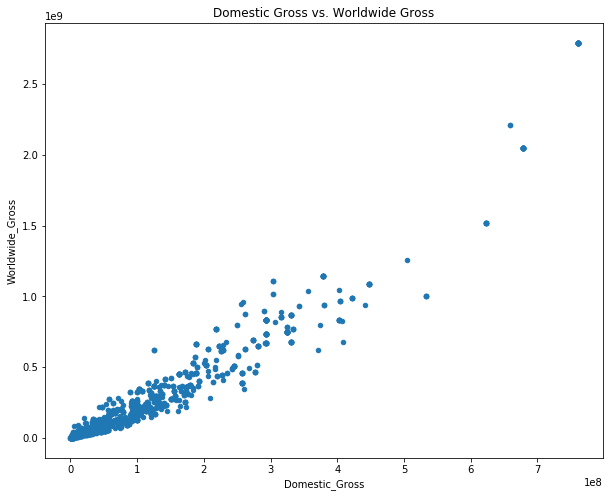

In [102]:
all_data.plot.scatter(x='Domestic_Gross', y='Worldwide_Gross', figsize=(10,8), 
                          title="Domestic Gross vs. Worldwide Gross")

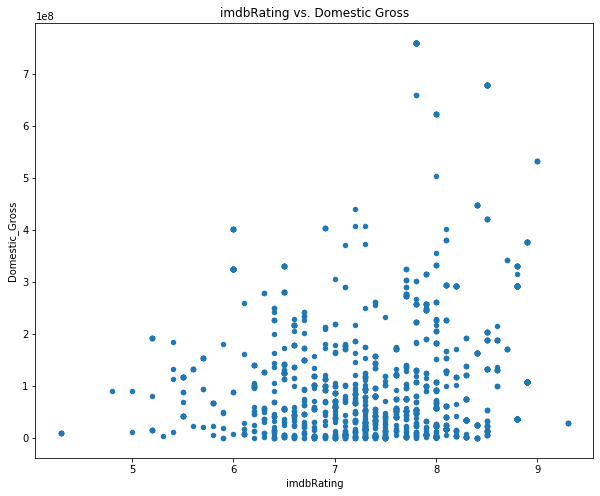

In [103]:
all_data.plot.scatter(x='imdbRating', y='Domestic_Gross', figsize=(10,8), 
                          title="imdbRating vs. Domestic Gross")

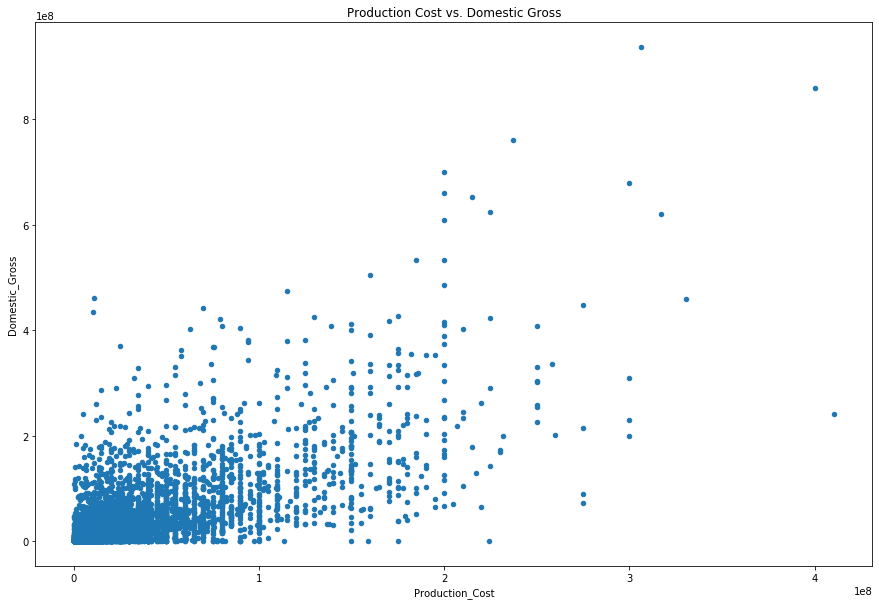

In [89]:
numbers_data = numbers_data.rename({'Domestic_Growth': 'Domestic_Gross', 
                                    'Worldwide_Growth': 'Worldwide_Gross'}, axis=1)
numbers_data.plot.scatter(x='Production_Cost', y='Domestic_Gross', figsize=(15,10), 
                          title="Production Cost vs. Domestic Gross")

In [90]:
type(all_data['Tomatoscore'][0])
print(all_data.iloc[33]['Tomatoscore'])
print(all_data.iloc[30]['Tomatoscore'])
# all_data['Tomatoscore'] = all_data.apply(lambda row: int(row['Tomatoscore'].replace('%','')), axis=1)
# all_data.head()

68/100
97%


Questions: 
1. How can we clean up our data (tomtato score)? 
2. How can we clean awards into a column with # awards and a column with # nominations?
3. We want to predict success/domestic gross. How can we include actors, writers, directors, etc? We were thinking of one-hot encoding, but this would be very extensive. 